<a href="https://colab.research.google.com/github/Stefanie04/MindMate/blob/main/Notebook_Stefanie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Start ▶

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from google.colab import drive
drive.mount('/content/drive')

import json

import io
import re
import random
import string
import tqdm

import tensorflow as tf
from tensorflow.keras import layers

import nltk
nltk.download('punkt')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [140]:
with open('/content/drive/MyDrive/TechLabs - pocket therapist/intents-rev2.json', 'r') as f:
    json_string = f.read()

In [3]:
#csv_df=pd.read_csv('/content/drive/MyDrive/TechLabs - pocket therapist/Mental_Health_FAQ.csv')

In [59]:
#excel_df = pd.read_excel('/content/drive/MyDrive/TechLabs - pocket therapist/Mental_Health_FAQ_rev1.xlsx')

# Preperation of the dataset 🚧

In [141]:
json_dict = json.loads(json_string)

intents = json_dict['intents']

In [142]:
df =pd.DataFrame(intents)

In [143]:
tags = []
patterns = []
responses = {}
for intents in json_dict['intents']:
    responses[intents['tag']]=intents['responses']
    for lines in intents['patterns']:
      patterns.append(lines)
      tags.append(intents['tag'])

In [144]:
json_df = pd.DataFrame({'tags':tags, 'patterns':patterns})

In [145]:
pd.set_option('display.max_rows', json_df.shape[0]+1)

In [146]:
json_df['tags']

0                                               greeting
1                                               greeting
2                                               greeting
3                                               greeting
4                                               greeting
5                                               greeting
6                                               greeting
7                                               greeting
8                                               greeting
9                                               greeting
10                                              greeting
11                                              greeting
12                                               morning
13                                             afternoon
14                                               evening
15                                                 night
16                                               goodbye
17                             

In [60]:
excel_df.rename(columns={'Question_ID': 'tags', 'Questions': 'patterns', 'Answers' : 'responses'}, inplace=True)

In [61]:
excel_df['tags'] = excel_df['tags'].astype(str)

In [62]:
excel_df

,tags,patterns,responses
0,meanmentalillness,What does it mean to have a mental illness?,Mental illnesses are health conditions that di...
1,affectmentalillness,Who does mental illness affect?,It is estimated that mental illness affects 1 ...
2,causesmentalillness,What causes mental illness?,It is estimated that mental illness affects 1 ...
3,signsmentalillness,What are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...
4,recovermentalillness,Can people with mental illness recover?,"When healing from mental illness, early identi..."
5,todomentaldisorder,What should I do if I know someone who appears...,Although this chatbot cannot substitute for pr...
6,findmentalhealthprofessional,How can I find a mental health professional fo...,Feeling comfortable with the professional you ...
7,treatmentoptions,What treatment options are available?,Just as there are different types of medicatio...
8,involvedtreatment,"If I become involved in treatment, what do I n...",Since beginning treatment is a big step for in...
9,differencementalhealthprofessionals,What is the difference between mental health p...,There are many types of mental health professi...


In [63]:
print(excel_df.dtypes)

tags         object
patterns     object
responses    object
dtype: object


In [64]:
new_excel_df = excel_df.drop(columns=['responses'])

In [65]:
total_df = pd.concat([json_df, new_excel_df], axis=0)

In [66]:
total_df

,tags,patterns
0,greeting,Hi
1,greeting,Hey
2,greeting,Is anyone there?
3,greeting,Hi there
4,greeting,Hello
...,...,...
91,helpalcoholdruguse,How can I find help for an alcohol or drug use...
92,drinkingtoomuch,How do I know if I'm drinking too much?
93,convincekidsdrugs,How can I convince my kids not to use drugs?
94,CBDoil,What is the legal status (and evidence) of CBD...


# Pre-Processing 🏗

## Lowercases / removing punctuation

In [147]:
pre_df = json_df.apply(lambda x: x.astype(str).str.lower())

import string
pre_df = pre_df.apply(lambda x: x.astype(str).str.replace('[{}]'.format(string.punctuation),''))

<ipython-input-147-8915ed0c4154>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  pre_df = pre_df.apply(lambda x: x.astype(str).str.replace('[{}]'.format(string.punctuation),''))


In [148]:
pre_df

,tags,patterns
0,greeting,hi
1,greeting,hey
2,greeting,is anyone there
3,greeting,hi there
4,greeting,hello
5,greeting,hey there
6,greeting,howdy
7,greeting,hola
8,greeting,bonjour
9,greeting,konnichiwa


## Tokenization

In [149]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Create a Tokenizer object
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(pre_df['patterns'])
tokenized_text = tokenizer.texts_to_sequences(pre_df['patterns'])

from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(tokenized_text)

from sklearn.preprocessing import LabelEncoder
# Create a LabelEncoder object
encoder = LabelEncoder()
y_train = encoder.fit_transform(pre_df['tags'])

In [150]:
# Creating the word list
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 443 unique tokens.


In [151]:
print(x_train.shape)
print(y_train.shape)

(330, 21)
(330,)


In [152]:
output_length = encoder.classes_.shape[0]
print('Output length: ', output_length)

Output length:  166


# Model 🕸

In [153]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Flatten, Dense, Dropout

In [154]:
input_size = x_train.shape[1]
output_size = encoder.classes_.shape[0]

In [155]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, 16, input_shape=(input_size,)))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(output_length, activation='sigmoid'))

In [156]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [157]:
train = model.fit(x_train, y_train, epochs=200)

Epoch 1/200
11/11 [==============================] - 5s 28ms/step - loss: 5.1107 - accuracy: 0.0091
Epoch 2/200
11/11 [==============================] - 0s 28ms/step - loss: 5.0810 - accuracy: 0.0242
Epoch 3/200
11/11 [==============================] - 0s 27ms/step - loss: 4.9454 - accuracy: 0.0303
Epoch 4/200
11/11 [==============================] - 0s 27ms/step - loss: 4.8138 - accuracy: 0.0333
Epoch 5/200
11/11 [==============================] - 0s 26ms/step - loss: 4.7857 - accuracy: 0.0333
Epoch 6/200
11/11 [==============================] - 0s 26ms/step - loss: 4.7433 - accuracy: 0.0333
Epoch 7/200
11/11 [==============================] - 0s 38ms/step - loss: 4.7071 - accuracy: 0.0364
Epoch 8/200
11/11 [==============================] - 0s 40ms/step - loss: 4.6869 - accuracy: 0.0394
Epoch 9/200
11/11 [==============================] - 0s 39ms/step - loss: 4.6311 - accuracy: 0.0424
Epoch 10/200
11/11 [==============================] - 0s 41ms/step - loss: 4.5776 - accuracy: 0.0515

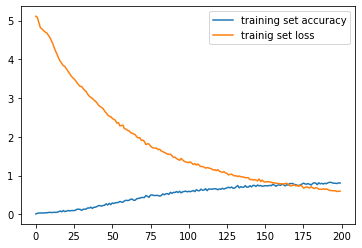

In [158]:
plt.plot(train.history['accuracy'], label='training set accuracy')
plt.plot(train.history['loss'], label='trainig set loss')
plt.legend()

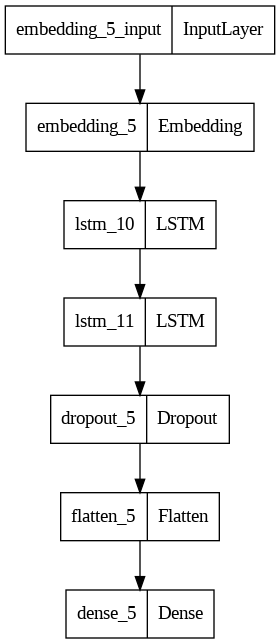

In [159]:
tf.keras.utils.plot_model(model)

#Chatbot 🤖

In [162]:
while True:
  conversation = []
  user_input = input('User: ')
  if user_input == 'bye':
    print('Goodbye and take care.')
    break

  # converting lowercase / removing punctuation 
  user_input = user_input.lower()
  user_input = re.sub(r'[^\w\s]', '', user_input)
  conversation.append(user_input)

  # tokenizer / padding
  user_input = tokenizer.texts_to_sequences(conversation)
  user_input = np.array(user_input).reshape(-1)
  user_input = pad_sequences([user_input], input_size)

  # output
  output = model.predict(user_input)
  output = output.argmax()

  # prediction
  response = encoder.inverse_transform([output])[0]
  print('response=' + response)
  if response in responses:
    print('Pocket Therapist: ', random.choice(responses[response]))
  else:
    print('Sorry, I do not understand. Can you please rephrase?')
  if response == 'goodbye':
    break

User: hi
1/1 [==============================] - 0s 27ms/step
response=greeting
Pocket Therapist:  Hello there. Tell me how are you feeling today?
User: bye
Goodbye and take care.
